# Support Vector Machines

_Adapted from Yish's interpretation of Chapter 9 of [Introduction to Statistical Learning in R](https://drive.google.com/file/d/1AXBbej19VmspqyaeicA1tmrUpsHYbZEx/view?usp=sharing)_

## Support Vector Classifier

SVMs approach the classification problem in a direct way - __we try and find a plane that separates the classes in the feature space__.

If we cannot, we do one of the two things:

- We __soften__ what we mean by "separates" 
- We __enlarge__ the feature space so that the separation is possible

__Notes on Terminology__:

- Support vector machines are sometimes used as a general method that incorporate maximal margin classifier, support vector classifiers etc. However, strictly by definition, support vector machine is a support vector classifier utilized with non-linear kernel. 

> "When the support vector classifier is combined with a non-linear kernel such as [a polynomial kernel of degree d], the resulting classifier is known as a support vector machine." -- P366, ISLR


Example of a boundary hyperplane in a two dimensional space:

<img src="images/exampleboundary.png" width=500>

### Maximal Margin Classifier

SVM tackles the problem of classification directly, in the sense that it does not compute a probabilistic model. Instead, it constructs a hyperplane to directly separate the classes. 

For example:

![](images/manyboundaries.png)

However, the problem with this approach is that we can come up with infinite number of such hyperplanes as we can tilt the line back and forth and it would still serve the same purpose.

__Therefore, we are using the hyperplane such that the it would be the farthest from training observations from either side__. The intuition behind it is that if we have chosen a hyperplane that is far from the training observations, it would be far for the testing observations as well. <br>

The distance between the training observations and the hyperplane is called the _margin_, and the classifier aims to find the maximal margin from the hyperplane that separates the training examples:

<img src="images/bestboundary.png" width=500>

## Soft Margin Classifier

Even though the maximal margin classifier sounds like an intuitive idea and not too difficult to optimize for, it might not be desirable under two circumstances:

1. It will be sensitive to individual training observations
2. The algorithm will not converge if the training observations cannot be linearly separated.

![](images/softboundary.png)

What happens if we cannot come up with a hyperplane that perfectly separates the training observations like the ones above? The first solution is the soft margin classifier, where we can loosen up our definition of the margin. 

<img src="images/withoutboundary.png" width=500>

__Rather than seeking the largest possible margin so that every observation is not only on the correct side of the hyperplane but also on the correct side of the margin, we instead allow some observations to be on the incorrect side of the margin, or even on the incorrect side of the hyperplane.__

![](images/errortolerance.png)

In this case, the hyperparameter ε is known as the slack variables, which dictate how many training observations we allow to violate the rule of margins or even the hyperplane. The amount of slack is bounded by C accordingly.

The parameter εi tells us where the ith training observation is located. 
- If εi = 0, then we say the ith training observation is on the correct side of the margin;
- If εi > 0, then we say it has violated the margin
- If εi > 1, then it is on the wrong side of the hyperplane

The value C is the sum of ε across all i training observations. The parameter C controls the bias-variance tradeoff of the statistical technique. A high value of C meaning we are more tolerant of the violation, which in turn might give us a model that has high bias but low variance; however, a low value of C indicates low tolerance of the violation, potentially giving us more variance but less bias. 

__How do we determine the ideal value of C?__

![](images/impactofchyperparameter.png)

__Note!__

In scikit-learn implementation, `c` is defined as the inverse. A higher value of `c` is a smaller regularization or smaller penalty, whereas a lower value of `c` is a higher penalty.

__Note!__
It is important to point out that in the support vector classfier (or SVM) in general, only the vectors on the margins are used for classification. They are called the __"Support Vectors"__

## "The Kernel Trick"

Sometimes we have training data that are not able to be separated even with softened margin:

![](images/needforkerneltrick.png)

The intuition to find the optimal fit is called feature space expansion:

- First, we __enlarge__ the feature space through the use of kernel
- Fit a support vector classifier in the enlarged space 
- This results in nonlinear decision boundaries in the original space 


<img src="images/nonlinearring.png" width=500>

<img src="images/nonlinearringin3d.png" width=500>

Why do we know that enlarging the feature space makes the data more linearly separable? [Cover's Theorem](https://en.wikipedia.org/wiki/Cover%27s_theorem).

Another view:

![](images/kernel_trick_hyperdimensional.png)

## Implementation & Performance Comparison

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  
from time import time

In [7]:
df = pd.read_csv('data/data_banknote_authentication.csv', header = None)
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1372 non-null   float64
 1   1       1372 non-null   float64
 2   2       1372 non-null   float64
 3   3       1372 non-null   float64
 4   4       1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [9]:
# our data needs column names
headers = ["Variance", "Skewness", "Curtosis", "Entropy", "Class"]
df.columns = headers

df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [10]:
# define X and y, then train test split
X = df.drop('Class', axis=1)  
y = df['Class'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### First: Linear Kernel

In [19]:
from sklearn.svm import SVC
tic = time() #timing!

svc_linear = SVC(kernel='linear', C=1)
svc_linear.fit(X_train_scaled, y_train)

y_pred_train = svc_linear.predict(X_train_scaled)
y_pred_test = svc_linear.predict(X_test_scaled)

toc = time()
print(f"Run time is {toc-tic} seconds")

Run time is 0.008567094802856445 seconds


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       160
           1       0.97      1.00      0.98       115

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

Train accuracy: 0.9845
Test accuracy: 0.9855


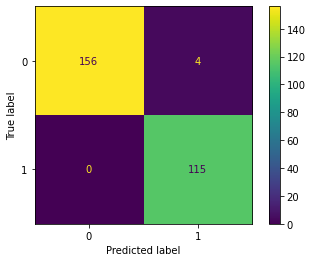

In [20]:
# how'd we do?
from sklearn.metrics import classification_report, plot_confusion_matrix , accuracy_score

print(classification_report(y_test, y_pred_test)) 
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

plot_confusion_matrix(svc_linear, X_test_scaled, y_test)
plt.show()

### Now: RBF

In [21]:
tic = time() #timing!

svc_rbf = SVC(kernel='rbf', C=1, gamma='scale') # using all default values here
svc_rbf.fit(X_train_scaled, y_train)

y_pred_train = svc_rbf.predict(X_train_scaled)
y_pred_test = svc_rbf.predict(X_test_scaled)

toc = time()
print(f"Run time is {toc-tic} seconds")

Run time is 0.008354902267456055 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       115

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Train accuracy: 1.0000
Test accuracy: 1.0000


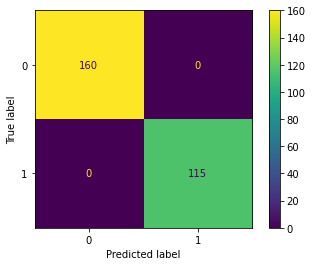

In [22]:
# how'd we do?
print(classification_report(y_test, y_pred_test)) 
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

plot_confusion_matrix(svc_rbf, X_test_scaled, y_test)
plt.show()

In [33]:
len(X_train)

1097

In [34]:
len(svc_rbf.support_)

90

In [40]:
svc_rbf.support_vectors_

array([[ 0.02737761, -0.87447762,  0.39702673,  0.09752888],
       [-0.02210474, -0.20249904, -0.1396701 ,  0.35677452],
       [ 0.04547745, -0.32674345, -0.02808742,  0.30032084],
       [-1.11259381,  1.74059152, -0.15821506, -3.5301354 ],
       [ 0.31212252,  0.23497794, -0.25955993,  0.51244661],
       [-0.02210474, -0.20249904, -0.1396701 ,  0.35677452],
       [ 1.46133867,  0.21747277, -0.79841985,  0.71215448],
       [-0.25510039,  1.06232123, -1.03504693, -0.64241238],
       [ 0.02737761, -0.87447762,  0.39702673,  0.09752888],
       [-0.13822038,  0.87018721, -0.78659194, -0.94132428],
       [ 0.59690285,  0.55590602, -0.72745243,  0.0057257 ],
       [-0.22966852,  1.23696699, -1.16635046, -2.69656834],
       [-0.43535147,  1.29541903, -1.18528891, -3.02900711],
       [ 0.04547745, -0.32674345, -0.02808742,  0.30032084],
       [-0.02210474, -0.20249904, -0.1396701 ,  0.35677452],
       [-0.11505152,  0.73894073, -0.670476  , -0.61699144],
       [ 0.74060357,  0.

### And a Polynomial Kernel for good measure

In [23]:
tic = time() #timing!

svc_poly = SVC(kernel='poly', C=1, gamma='scale', degree=3) # using mostly default values here
svc_poly.fit(X_train_scaled, y_train)

y_pred_train = svc_poly.predict(X_train_scaled)
y_pred_test = svc_poly.predict(X_test_scaled)

toc = time()
print(f"Run time is {toc-tic} seconds")

Run time is 0.00989985466003418 seconds


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       160
           1       0.96      1.00      0.98       115

    accuracy                           0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275

Train accuracy: 0.9872
Test accuracy: 0.9818


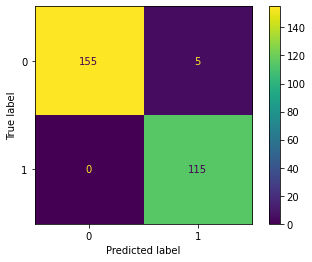

In [24]:
# how'd we do?
print(classification_report(y_test, y_pred_test)) 
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

plot_confusion_matrix(svc_poly, X_test_scaled, y_test)
plt.show()

### Adjusting C?

-----
Results at C = 0.001
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       160
           1       0.00      0.00      0.00       115

    accuracy                           0.58       275
   macro avg       0.29      0.50      0.37       275
weighted avg       0.34      0.58      0.43       275

Train accuracy: 0.5488
Test accuracy: 0.5818


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


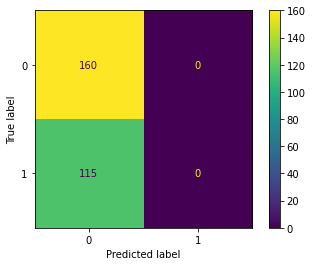

-----
Results at C = 0.01
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       160
           1       0.91      0.92      0.91       115

    accuracy                           0.93       275
   macro avg       0.92      0.93      0.93       275
weighted avg       0.93      0.93      0.93       275

Train accuracy: 0.9316
Test accuracy: 0.9273


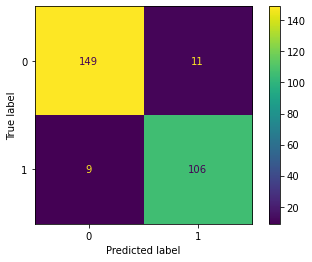

-----
Results at C = 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       115

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Train accuracy: 1.0000
Test accuracy: 1.0000


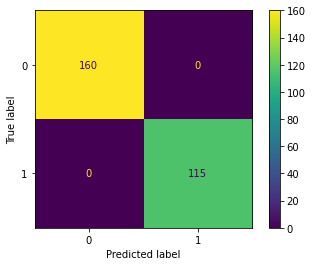

-----
Results at C = 100
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       115

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Train accuracy: 1.0000
Test accuracy: 1.0000


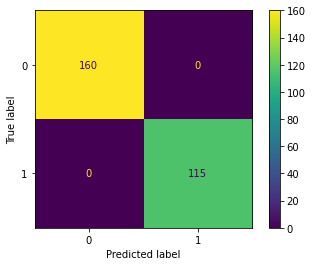

In [26]:
for c in [.001, .01, 1, 100]: 
    svc_c = SVC(kernel='rbf', C=c, gamma='scale') # going rbf again
    svc_c.fit(X_train_scaled, y_train)

    y_pred_train = svc_c.predict(X_train_scaled)
    y_pred_test = svc_c.predict(X_test_scaled)

    # how'd we do?
    print("-----")
    print(f'Results at C = {c}')
    print(classification_report(y_test, y_pred_test)) 
    print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

    plot_confusion_matrix(svc_c, X_test_scaled, y_test)
    plt.show()

## Pros 

- Good performance
- Good off-the-shelf model in general for several scenarios
- Can approximate complex non-linear functions
- Stable model that generalizes well (since the back end only cares about the support vectors)

## Cons 

- Long training time required
- Tuning required to determine optimal kernel for non-linear SVMs
- Difficult to interpret

## Requirements

- Scaled features
- Null values filled

## Resources

- [Reddit Post: Explain Support Vector Machines Like I'm 5](https://www.reddit.com/r/MachineLearning/comments/15zrpp/please_explain_support_vector_machines_svm_like_i/) - top comment is super straightforward and has easily understandable images showcasing what's discussed
- [Advantages and Disadvantages of SVMs](http://theprofessionalspoint.blogspot.com/2019/03/advantages-and-disadvantages-of-svm.html) - summarized above
- [An Idiot's Guide to Support Vector Machines (SVMs) from MIT](https://web.mit.edu/6.034/wwwbob/svm.pdf) - this goes way deep into the math behind how to solve this problem computationally, but the intro is fairly straightforward
- [Machine Learning Mastery's Post on Support Vector Machines for Machine Learning](https://machinelearningmastery.com/support-vector-machines-for-machine-learning/) - not my favorite post from MLM, but effective